Epoch 1/20, Loss: 0.0764
Epoch 2/20, Loss: 0.0323
Epoch 3/20, Loss: 0.0199
Epoch 4/20, Loss: 0.0170
Epoch 5/20, Loss: 0.0155
Epoch 6/20, Loss: 0.0149
Epoch 7/20, Loss: 0.0144
Epoch 8/20, Loss: 0.0140
Epoch 9/20, Loss: 0.0138
Epoch 10/20, Loss: 0.0134
Epoch 11/20, Loss: 0.0131
Epoch 12/20, Loss: 0.0123
Epoch 13/20, Loss: 0.0111
Epoch 14/20, Loss: 0.0106
Epoch 15/20, Loss: 0.0097
Epoch 16/20, Loss: 0.0092
Epoch 17/20, Loss: 0.0089
Epoch 18/20, Loss: 0.0086
Epoch 19/20, Loss: 0.0084
Epoch 20/20, Loss: 0.0082


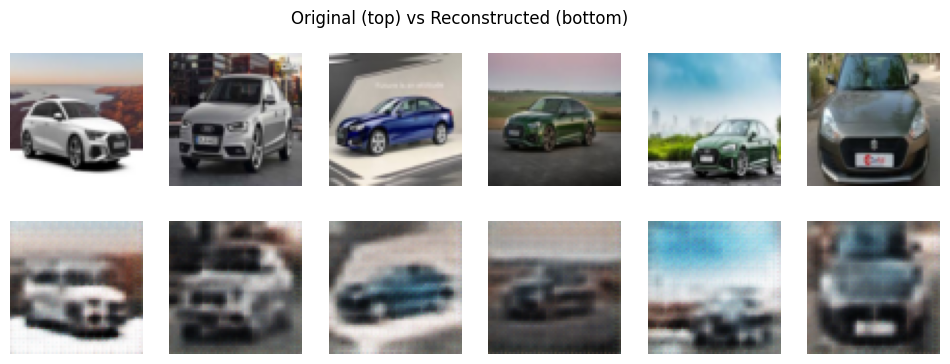

In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 1. Гіперпараметри
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
IMG_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Трансформації
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# 3. Завантаження датасету (лише Audi та Swift)
data_dir = "/content/drive/MyDrive/Cars Dataset/train"
allowed_classes = ['Audi', 'Swift']

class FilteredDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [s for s in self.samples if self.classes[s[1]] in allowed_classes]
        self.targets = [s[1] for s in self.samples]

dataset = FilteredDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4. Архітектура автоенкодера
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 8x8
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 64x64
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 5. Навчання
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

# 6. Візуалізація результатів
def show_reconstructions(model, dataloader, n=6):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images[:n].to(DEVICE)
    with torch.no_grad():
        recon = model(images)
    images = images.cpu()
    recon = recon.cpu()

    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Оригінал
        plt.subplot(2, n, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
        # Відновлене
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].permute(1, 2, 0))
        plt.axis('off')
    plt.suptitle("Original (top) vs Reconstructed (bottom)")
    plt.show()

show_reconstructions(model, dataloader)
